In [21]:
# =========================================================
# AADHAAR DATA ANALYTICS PIPELINE
# Spatial Inequality + Anomaly Detection
# =========================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL

PART 1: RAW DATA INGESTION & MASTER DATASET CREATION

In [22]:
# ---------------------------------------------------------
# 1. Define file groups (UIDAI chunked datasets)
# ---------------------------------------------------------

enrolment_files = [
    'api_data_aadhar_enrolment_0_500000.csv',
    'api_data_aadhar_enrolment_500000_1000000.csv',
    'api_data_aadhar_enrolment_1000000_1006029.csv'
]

demo_files = [
    'api_data_aadhar_demographic_0_500000.csv',
    'api_data_aadhar_demographic_500000_1000000.csv',
    'api_data_aadhar_demographic_1000000_1500000.csv',
    'api_data_aadhar_demographic_1500000_2000000.csv',
    'api_data_aadhar_demographic_2000000_2071700.csv'
]

bio_files = [
    'api_data_aadhar_biometric_0_500000.csv',
    'api_data_aadhar_biometric_500000_1000000.csv',
    'api_data_aadhar_biometric_1000000_1500000.csv',
    'api_data_aadhar_biometric_1500000_1861108.csv'
]

# ---------------------------------------------------------
# 2. Load and vertically stack helper
# ---------------------------------------------------------

def load_and_stack(files, label):
    print(f"Loading {label} data...")
    dfs = [pd.read_csv(f) for f in files]
    df = pd.concat(dfs, ignore_index=True)
    df['date'] = pd.to_datetime(df['date'], dayfirst=True)
    return df

df_enrol = load_and_stack(enrolment_files, "Enrolment")
df_demo  = load_and_stack(demo_files, "Demographic Updates")
df_bio   = load_and_stack(bio_files, "Biometric Updates")

# ---------------------------------------------------------
# 3. Horizontal merge
# ---------------------------------------------------------

merge_keys = ['date', 'state', 'district', 'pincode']

final_df = pd.merge(df_enrol, df_demo, on=merge_keys, how='outer')
final_df = pd.merge(final_df, df_bio, on=merge_keys, how='outer')

# Missing values imply no activity
final_df.fillna(0, inplace=True)

count_cols = [c for c in final_df.columns if c not in merge_keys]
final_df[count_cols] = final_df[count_cols].astype(int)

final_df.to_csv('aadhaar_master_dataset.csv', index=False)
print("Master dataset created.")

Loading Enrolment data...
Loading Demographic Updates data...
Loading Biometric Updates data...
Master dataset created.


PART 2: DATA CLEANING & STANDARDIZATION

In [23]:
# ---------------------------------------------------------
# Load master dataset
# ---------------------------------------------------------

df = pd.read_csv('aadhaar_master_dataset.csv')

# ---------------------------------------------------------
# State name standardization
# ---------------------------------------------------------

valid_states = [
    'Andhra Pradesh','Arunachal Pradesh','Assam','Bihar','Chhattisgarh',
    'Goa','Gujarat','Haryana','Himachal Pradesh','Jharkhand','Karnataka',
    'Kerala','Madhya Pradesh','Maharashtra','Manipur','Meghalaya','Mizoram',
    'Nagaland','Odisha','Punjab','Rajasthan','Sikkim','Tamil Nadu','Telangana',
    'Tripura','Uttar Pradesh','Uttarakhand','West Bengal',
    'Andaman and Nicobar Islands','Chandigarh',
    'Dadra and Nagar Haveli and Daman and Diu','Delhi',
    'Jammu and Kashmir','Ladakh','Lakshadweep','Puducherry'
]

state_mapping = {
    'Jammu & Kashmir': 'Jammu and Kashmir',
    'Jammu And Kashmir': 'Jammu and Kashmir',
    'Chhatisgarh': 'Chhattisgarh',
    'Orissa': 'Odisha',
    'The Dadra And Nagar Haveli And Daman And Diu': 'Dadra and Nagar Haveli and Daman and Diu',
    'Dadra & Nagar Haveli': 'Dadra and Nagar Haveli and Daman and Diu',
    'Daman & Diu': 'Dadra and Nagar Haveli and Daman and Diu',
    'Uttaranchal': 'Uttarakhand',
    'Pondicherry': 'Puducherry'
}

def clean_state(name):
    if not isinstance(name, str):
        return "Remove"
    
    name = name.strip().lower()

    # Reverse mapping with lowercase keys
    mapping_lower = {k.lower(): v for k, v in state_mapping.items()}
    valid_lower = {s.lower(): s for s in valid_states}

    # Direct mapping
    if name in mapping_lower:
        return mapping_lower[name]

    # Match valid states ignoring case
    if name in valid_lower:
        return valid_lower[name]

    return "Remove"


df['state'] = df['state'].apply(clean_state)
df = df[df['state'] != "Remove"].copy()

In [24]:
print("Unique states after cleaning:", df['state'].nunique())
print(df['state'].value_counts().head())

Unique states after cleaning: 36
state
Andhra Pradesh    290057
Tamil Nadu        286871
Uttar Pradesh     238561
West Bengal       230612
Maharashtra       228172
Name: count, dtype: int64


PART 3: FEATURE ENGINEERING

In [25]:
# ---------------------------------------------------------
# Aadhaar activity metrics
# ---------------------------------------------------------

df['total_updates'] = (
    df['demo_age_5_17'] + df['demo_age_17_'] +
    df['bio_age_5_17']  + df['bio_age_17_']
)

df['total_new_enrolments'] = (
    df['age_0_5'] + df['age_5_17'] + df['age_18_greater']
)

PART 4: SPATIAL INEQUALITY (GINI + LORENZ CURVE)

Gini Coefficient (Spatial Inequality): 0.616


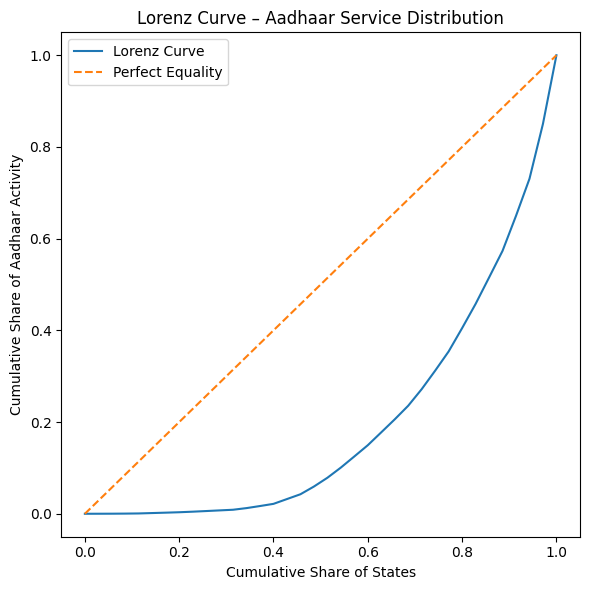

In [26]:
# ---------------------------------------------------------
# State-level aggregation
# ---------------------------------------------------------

state_activity = df.groupby('state')['total_updates'].sum().values

# ---------------------------------------------------------
# Gini coefficient calculation
# ---------------------------------------------------------

def gini(array):
    array = np.sort(array)
    n = len(array)
    cumulative = np.cumsum(array)
    return (n + 1 - 2 * np.sum(cumulative) / cumulative[-1]) / n

gini_value = gini(state_activity)
print(f"Gini Coefficient (Spatial Inequality): {gini_value:.3f}")

# ---------------------------------------------------------
# Lorenz Curve
# ---------------------------------------------------------

sorted_vals = np.sort(state_activity)
cum_vals = np.cumsum(sorted_vals)
cum_vals = cum_vals / cum_vals[-1]

plt.figure(figsize=(6,6))
plt.plot(np.linspace(0,1,len(cum_vals)), cum_vals, label='Lorenz Curve')
plt.plot([0,1],[0,1],'--', label='Perfect Equality')
plt.xlabel('Cumulative Share of States')
plt.ylabel('Cumulative Share of Aadhaar Activity')
plt.title('Lorenz Curve – Aadhaar Service Distribution')
plt.legend()
plt.tight_layout()
plt.savefig('lorenz_curve.png')
plt.show()

PART 5: TIME-SERIES ANOMALY DETECTION (STL)

In [27]:
# ---------------------------------------------------------
# Ensure 'date' is datetime
# ---------------------------------------------------------
df['date'] = pd.to_datetime(df['date'], errors='coerce', dayfirst=True)

# Drop rows with invalid dates
df = df.dropna(subset=['date'])

# ---------------------------------------------------------
# Aggregate to monthly national level
# ---------------------------------------------------------
ts = df.set_index('date').resample('M')['total_updates'].sum()

# ---------------------------------------------------------
# STL decomposition
# ---------------------------------------------------------
from statsmodels.tsa.seasonal import STL

stl = STL(ts, period=12, robust=True)
result = stl.fit()

# Residuals represent anomalies
residuals = result.resid

# ---------------------------------------------------------
# Anomaly detection using Residual Threshold
# ---------------------------------------------------------
threshold = 3 * residuals.std()
anomalies = ts[np.abs(residuals) > threshold]

print("Detected anomaly dates:")
print(anomalies)

C:\Users\Reanna Netto\AppData\Local\Temp\ipykernel_3596\396394908.py:12: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  ts = df.set_index('date').resample('M')['total_updates'].sum()


Detected anomaly dates:
Series([], Freq: ME, Name: total_updates, dtype: int64)


In [28]:
print(ts.head())
print(ts.isna().sum())
print(len(ts))


date
2025-01-31    68262555
2025-02-28     2678803
2025-03-31     2674910
2025-04-30     2787871
2025-05-31     1805735
Freq: ME, Name: total_updates, dtype: int64
0
12


PART 6: STL VISUALIZATION

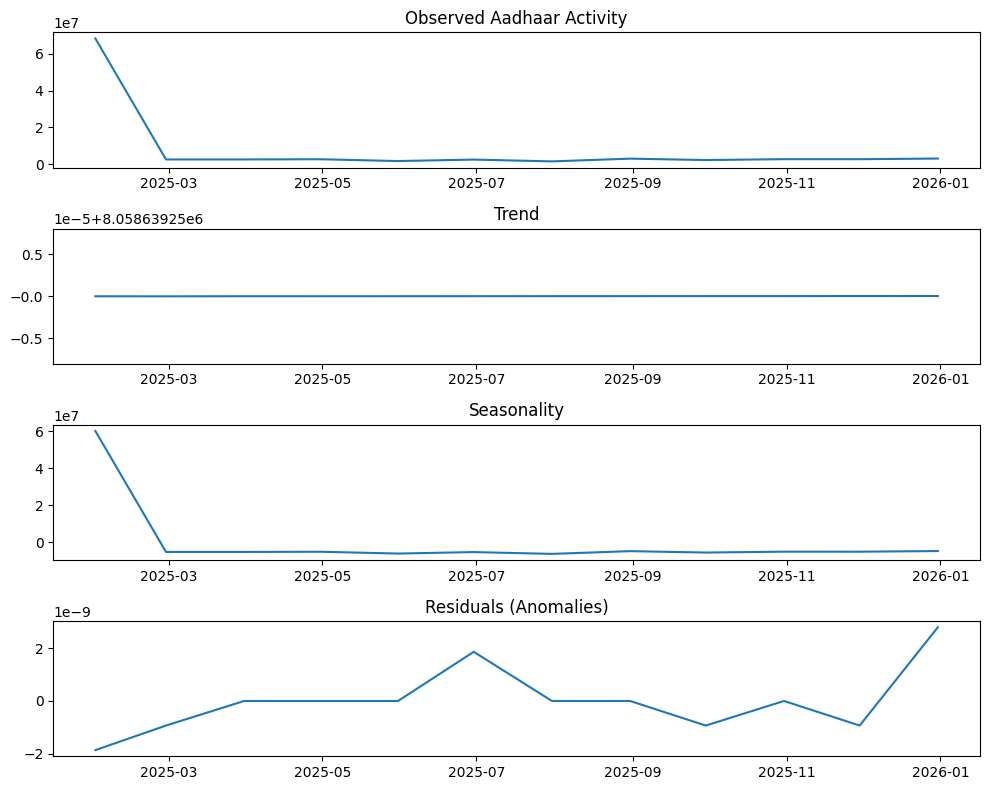

In [29]:
# ---------------------------------------------------------
# STL decomposition plots
# ---------------------------------------------------------
import matplotlib.pyplot as plt

plt.figure(figsize=(10,8))

plt.subplot(4,1,1)
plt.plot(ts)
plt.title('Observed Aadhaar Activity')

plt.subplot(4,1,2)
plt.plot(result.trend)
plt.title('Trend')

plt.subplot(4,1,3)
plt.plot(result.seasonal)
plt.title('Seasonality')

plt.subplot(4,1,4)
plt.plot(result.resid)
plt.title('Residuals (Anomalies)')

plt.tight_layout()
plt.show()

PART 7: FINAL EXPORT

In [30]:
df.to_csv('cleaned_master_dataset.csv', index=False)
print("Cleaned dataset exported successfully.")

Cleaned dataset exported successfully.


DISTRICT-LEVEL STAGNATION & ANOMALOUS SPIKES

District-level anomaly summary saved.

Top 10 districts by spike count:
                 state              district  mean_updates   std_updates  \
618             Odisha                Anugal      0.093023      0.293903   
164         Chandigarh                Mohali      0.093023      0.293903   
435             Kerala              Kottayam   1883.000000   3205.795370   
346          Jharkhand              Garhwa *    133.837209    226.362849   
648             Odisha               Khordha    490.000000    681.900810   
36      Andhra Pradesh  Parvathipuram Manyam    364.209302    694.855126   
837          Telangana             Vikarabad   1155.697674   1433.267970   
887      Uttar Pradesh   Gautam Buddha Nagar   4896.093023  11268.440423   
317  Jammu and Kashmir             Ganderbal    379.697674    764.715339   
602           Nagaland              Longleng     64.279070    132.902099   

     spike_count  stagnation_flag  
618            4                1  
164            4   

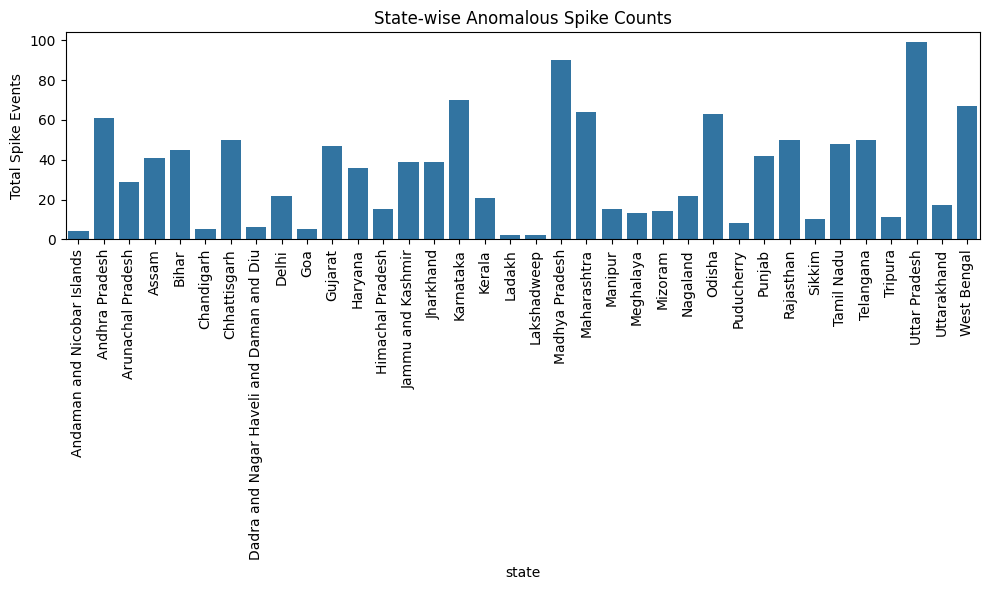

In [31]:
# 1️⃣ Aggregate monthly Aadhaar activity per district
district_ts = df.groupby(['state', 'district', 'date'])['total_updates'].sum().reset_index()

# Pivot to have districts as columns for time series
district_pivot = district_ts.pivot_table(index='date', columns=['state', 'district'], values='total_updates', fill_value=0)

# 2️⃣ Compute long-term average activity per district
district_mean = district_pivot.mean()
district_std = district_pivot.std()

# 3️⃣ Detect anomalous spikes
# Threshold = mean + 3*std for spikes
spike_flags = (district_pivot > (district_mean + 3 * district_std)).astype(int)

# 4️⃣ Detect stagnation zones
# Criteria: mean monthly updates < 10th percentile across districts
stagnation_threshold = np.percentile(district_mean, 10)
stagnation_flags = (district_mean < stagnation_threshold).astype(int)

# 5️⃣ Summarize results
district_summary = pd.DataFrame({
    'state': [s for s, d in district_mean.index],
    'district': [d for s, d in district_mean.index],
    'mean_updates': district_mean.values,
    'std_updates': district_std.values,
    'spike_count': spike_flags.sum().values,
    'stagnation_flag': stagnation_flags.values
})

# Sort by spike count and stagnation for easy inspection
district_summary = district_summary.sort_values(by=['stagnation_flag','spike_count'], ascending=[False, False])

# 6️⃣ Export summary
district_summary.to_csv('district_anomalies_summary.csv', index=False)
print("District-level anomaly summary saved.")

# 7️⃣ Optional: Top 10 districts by spikes and stagnation
print("\nTop 10 districts by spike count:")
print(district_summary.sort_values(by='spike_count', ascending=False).head(10))

print("\nTop 10 stagnation districts:")
print(district_summary[district_summary['stagnation_flag']==1].sort_values(by='mean_updates').head(10))

# 8️⃣ Heatmap visualization (optional)
import seaborn as sns

# Aggregate spike counts per state for a simple heatmap
state_spikes = district_summary.groupby('state')['spike_count'].sum()

plt.figure(figsize=(10,6))
sns.barplot(x=state_spikes.index, y=state_spikes.values)
plt.xticks(rotation=90)
plt.ylabel('Total Spike Events')
plt.title('State-wise Anomalous Spike Counts')
plt.tight_layout()
plt.show()

ORGANIC vs SYSTEMIC ANOMALIES PER DISTRICT

Updated district anomalies summary with organic/systemic flags saved.

Sample districts with organic spikes:
                  state          district  mean_updates  std_updates  \
164          Chandigarh            Mohali      0.093023     0.293903   
618              Odisha            Anugal      0.093023     0.293903   
118               Bihar    Aurangabad(BH)      0.232558     0.570597   
325   Jammu and Kashmir      Leh (ladakh)      0.069767     0.257770   
422           Karnataka           Udupi *      0.069767     0.257770   
615              Odisha             ANGUL      0.069767     0.257770   
796          Tamil Nadu         Tiruvarur      0.069767     0.257770   
979         West Bengal    East midnapore      0.069767     0.257770   
1012        West Bengal  South 24 Pargana      0.209302     0.558831   
1014        West Bengal  South 24 pargana      0.139535     0.515539   

      spike_count  stagnation_flag  organic_spike_flag  systemic_flag  
164             4         

C:\Users\Reanna Netto\AppData\Local\Temp\ipykernel_3596\1137566893.py:67: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='state', y='systemic_flag', data=state_flags, palette='Reds')


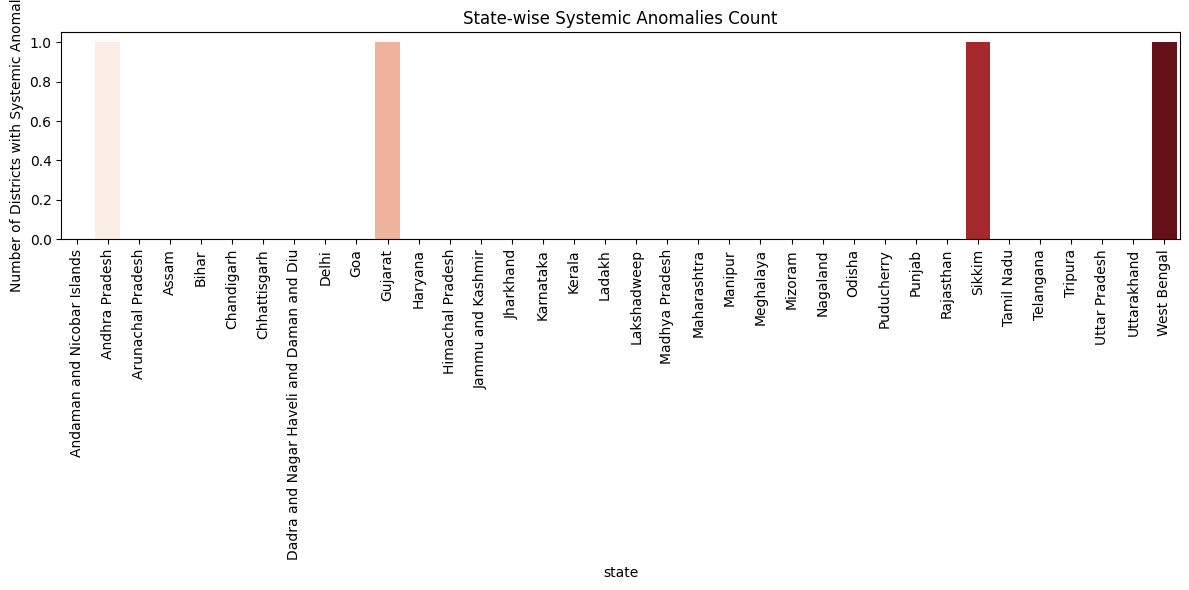

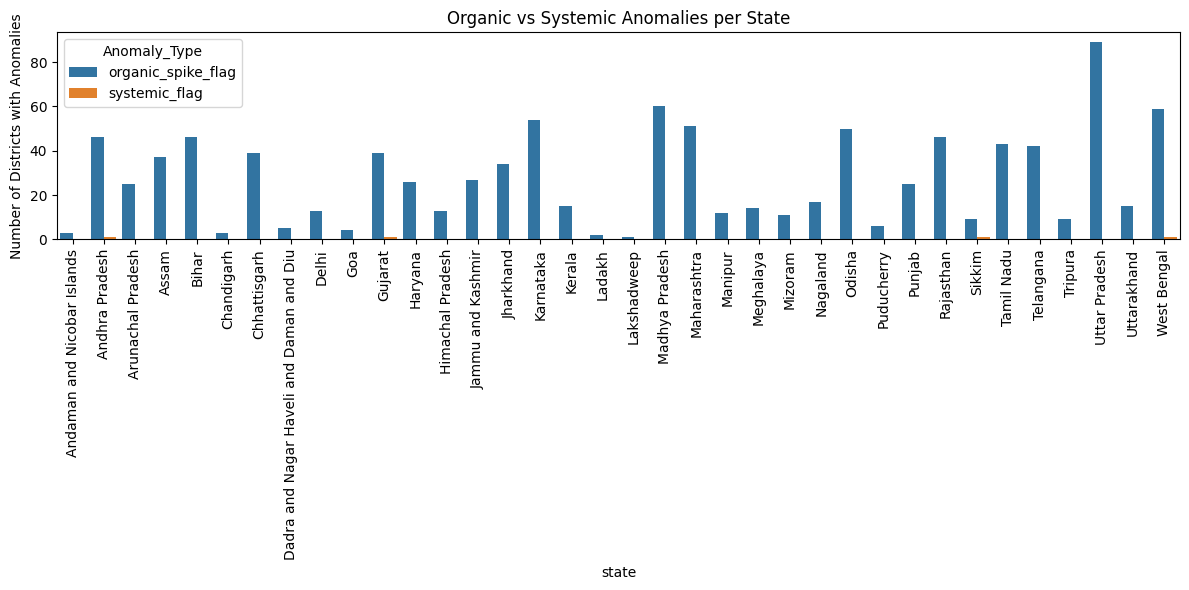

In [32]:
from statsmodels.tsa.seasonal import STL

organic_flags = []
systemic_flags = []

# Loop over each district
for state, district in district_pivot.columns:
    ts_d = district_pivot[(state, district)]
    
    # Skip districts with very low activity
    if ts_d.sum() < 1:
        organic_flags.append(0)
        systemic_flags.append(0)
        continue

    # STL decomposition
    try:
        stl = STL(ts_d, period=12, robust=True)
        res = stl.fit()
        resid = res.resid
        trend = res.trend
    except:
        organic_flags.append(0)
        systemic_flags.append(0)
        continue

    # Spike detection: short-term anomaly
    spike_threshold = 3 * resid.std()
    spike_count = (np.abs(resid) > spike_threshold).sum()

    # Determine organic vs systemic
    # Organic: isolated spikes (count <= 2)
    # Systemic: sustained deviations (trend far from mean or long residuals > threshold)
    mean_trend = trend.mean()
    if spike_count <= 2:
        organic_flags.append(1)
        systemic_flags.append(0)
    else:
        # Check for prolonged low activity: trend < 50% of mean trend
        if (trend < 0.5 * mean_trend).sum() > len(trend)//3:
            organic_flags.append(0)
            systemic_flags.append(1)
        else:
            organic_flags.append(1)
            systemic_flags.append(0)

# Add flags to district_summary
district_summary['organic_spike_flag'] = organic_flags
district_summary['systemic_flag'] = systemic_flags

# Save updated summary
district_summary.to_csv('district_anomalies_summary_with_types.csv', index=False)
print("Updated district anomalies summary with organic/systemic flags saved.")

# Quick inspection
print("\nSample districts with organic spikes:")
print(district_summary[district_summary['organic_spike_flag']==1].head(10))

print("\nSample districts with systemic anomalies:")
print(district_summary[district_summary['systemic_flag']==1].head(10))

# Aggregate organic/systemic flags per state
state_flags = district_summary.groupby('state')[['organic_spike_flag','systemic_flag']].sum().reset_index()

# 1️⃣ Heatmap for systemic anomalies
plt.figure(figsize=(12,6))
sns.barplot(x='state', y='systemic_flag', data=state_flags, palette='Reds')
plt.xticks(rotation=90)
plt.ylabel('Number of Districts with Systemic Anomalies')
plt.title('State-wise Systemic Anomalies Count')
plt.tight_layout()
plt.show()

# 2️⃣ Comparative barplot: Organic vs Systemic
state_flags_melted = state_flags.melt(
    id_vars='state', 
    value_vars=['organic_spike_flag', 'systemic_flag'],
    var_name='Anomaly_Type', 
    value_name='Count'
)

plt.figure(figsize=(12,6))
sns.barplot(x='state', y='Count', hue='Anomaly_Type', data=state_flags_melted)
plt.xticks(rotation=90)
plt.ylabel('Number of Districts with Anomalies')
plt.title('Organic vs Systemic Anomalies per State')
plt.tight_layout()
plt.show()

UNIVARIATE, BIVARIATE, TRIVARIATE ANALYSIS

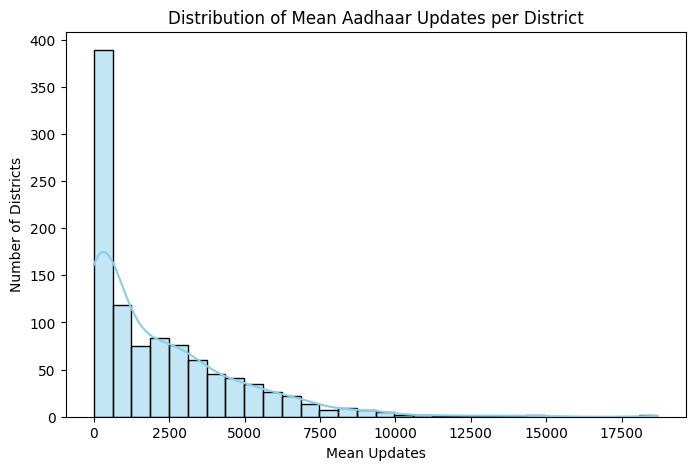

C:\Users\Reanna Netto\AppData\Local\Temp\ipykernel_3596\2792006500.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='stagnation_flag', data=district_summary, palette='pastel')


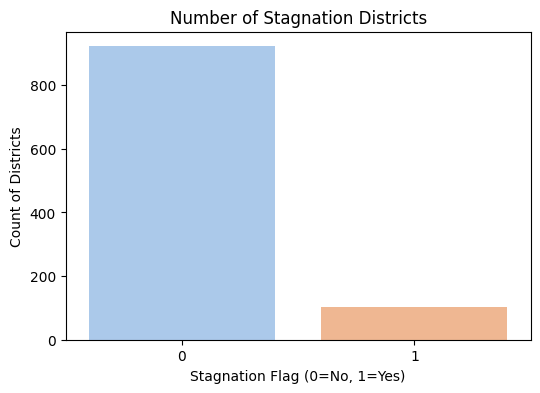

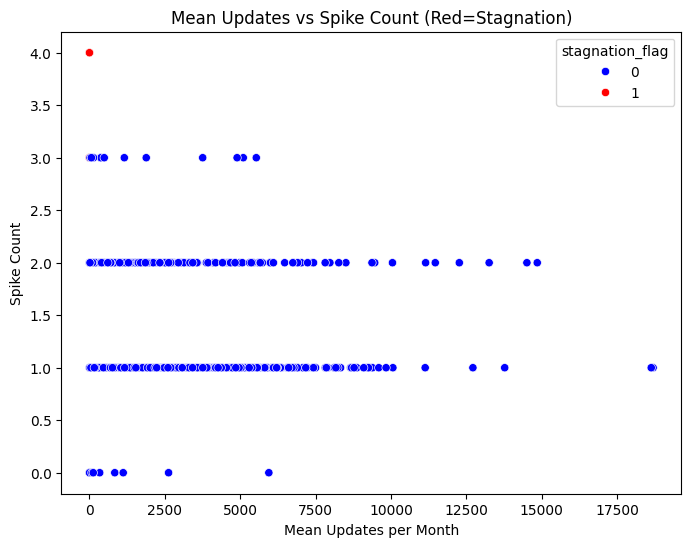

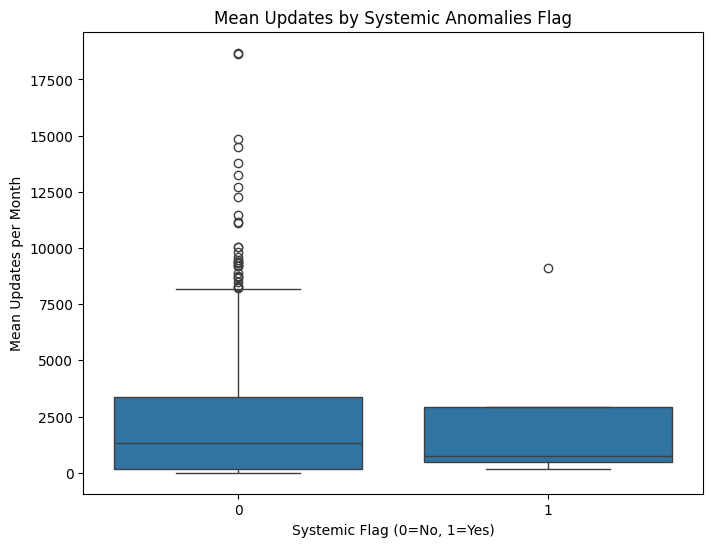

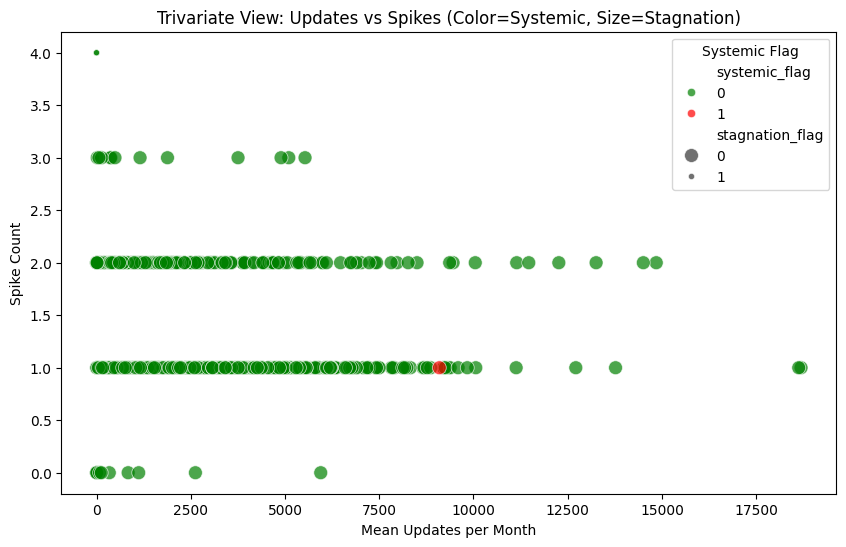

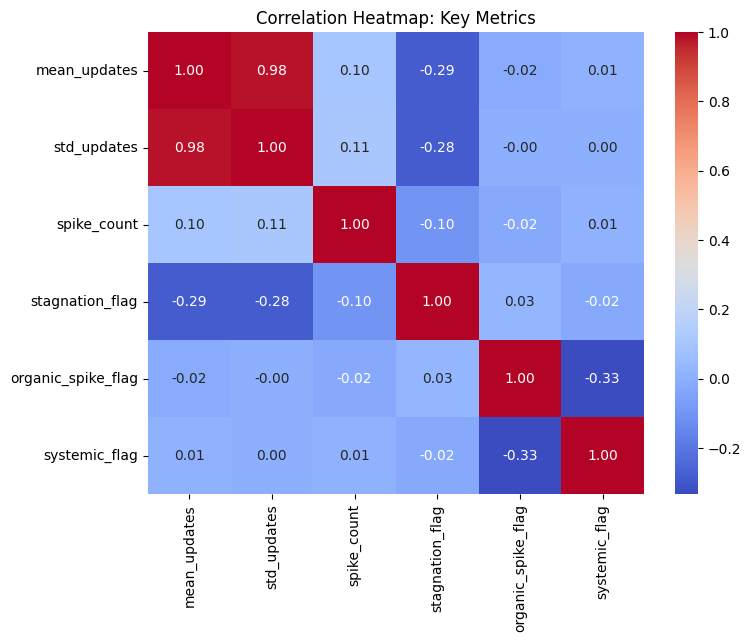

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt

# ------------------------------
# Univariate Analysis
# ------------------------------

# Distribution of mean updates per district
plt.figure(figsize=(8,5))
sns.histplot(district_summary['mean_updates'], bins=30, kde=True, color='skyblue')
plt.title('Distribution of Mean Aadhaar Updates per District')
plt.xlabel('Mean Updates')
plt.ylabel('Number of Districts')
plt.show()

# Count of districts flagged as stagnation zones
plt.figure(figsize=(6,4))
sns.countplot(x='stagnation_flag', data=district_summary, palette='pastel')
plt.title('Number of Stagnation Districts')
plt.xlabel('Stagnation Flag (0=No, 1=Yes)')
plt.ylabel('Count of Districts')
plt.show()

# ------------------------------
# Bivariate Analysis
# ------------------------------

# Scatter: mean_updates vs spike_count
plt.figure(figsize=(8,6))
sns.scatterplot(x='mean_updates', y='spike_count', data=district_summary, hue='stagnation_flag', palette=['blue','red'])
plt.title('Mean Updates vs Spike Count (Red=Stagnation)')
plt.xlabel('Mean Updates per Month')
plt.ylabel('Spike Count')
plt.show()

# Boxplot: mean_updates by systemic vs organic anomalies
plt.figure(figsize=(8,6))
sns.boxplot(x='systemic_flag', y='mean_updates', data=district_summary)
plt.title('Mean Updates by Systemic Anomalies Flag')
plt.xlabel('Systemic Flag (0=No, 1=Yes)')
plt.ylabel('Mean Updates per Month')
plt.show()

# ------------------------------
# Trivariate Analysis
# ------------------------------

# Example: Scatter with color by anomaly type (systemic vs organic)
plt.figure(figsize=(10,6))
sns.scatterplot(
    x='mean_updates',
    y='spike_count',
    data=district_summary,
    hue='systemic_flag',
    size='stagnation_flag',
    palette={0:'green',1:'red'},
    sizes=(20,100),
    alpha=0.7
)
plt.title('Trivariate View: Updates vs Spikes (Color=Systemic, Size=Stagnation)')
plt.xlabel('Mean Updates per Month')
plt.ylabel('Spike Count')
plt.legend(title='Systemic Flag')
plt.show()

# Optional: Correlation heatmap for multiple variables
corr_cols = ['mean_updates', 'std_updates', 'spike_count', 'stagnation_flag', 'organic_spike_flag', 'systemic_flag']
plt.figure(figsize=(8,6))
sns.heatmap(district_summary[corr_cols].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap: Key Metrics')
plt.show()


Trivariate Analysis Including Population

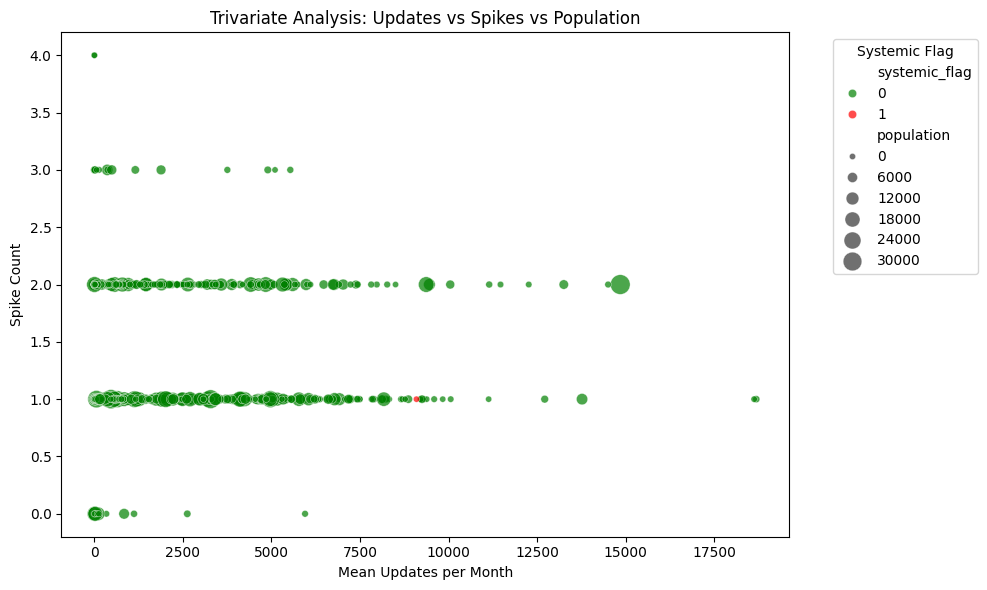

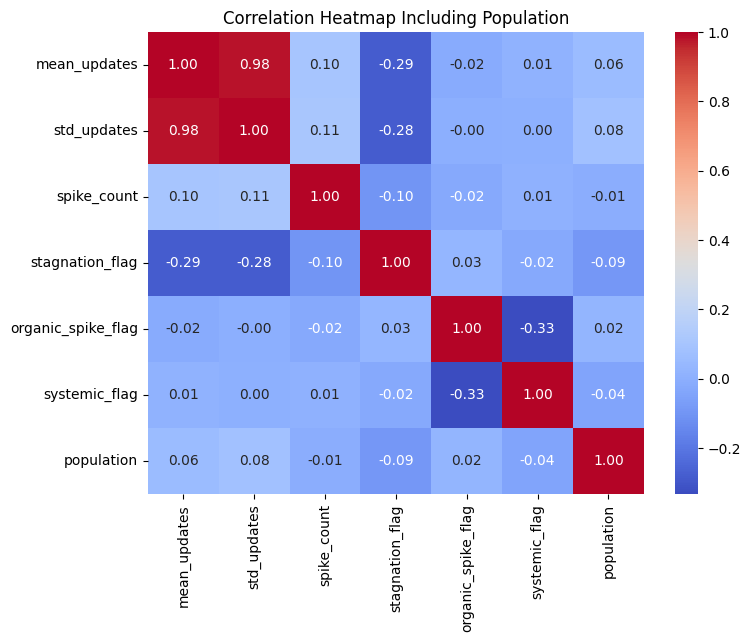

In [34]:
# Assuming 'population' column exists in district_summary
# If not, approximate from demographic age groups:
if 'population' not in district_summary.columns:
    district_summary['population'] = (
        df.groupby(['state','district'])[['age_0_5','age_5_17','age_18_greater']].sum().sum(axis=1).values
    )

# Trivariate Scatter: Updates vs Spikes, size by population
plt.figure(figsize=(10,6))
sns.scatterplot(
    x='mean_updates',
    y='spike_count',
    data=district_summary,
    hue='systemic_flag',          # color: systemic vs not
    size='population',            # size: district population
    sizes=(20,200),
    palette={0:'green',1:'red'},
    alpha=0.7
)
plt.title('Trivariate Analysis: Updates vs Spikes vs Population')
plt.xlabel('Mean Updates per Month')
plt.ylabel('Spike Count')
plt.legend(title='Systemic Flag', bbox_to_anchor=(1.05,1), loc='upper left')
plt.tight_layout()
plt.show()

# Optional: Correlation heatmap including population
corr_cols = ['mean_updates', 'std_updates', 'spike_count', 'stagnation_flag', 'organic_spike_flag', 'systemic_flag','population']
plt.figure(figsize=(8,6))
sns.heatmap(district_summary[corr_cols].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap Including Population')
plt.show()


Trend Analysis

C:\Users\Reanna Netto\AppData\Local\Temp\ipykernel_3596\1277572744.py:62: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=state_compliance, x='compliance_ratio', y='state', palette='Blues_r')


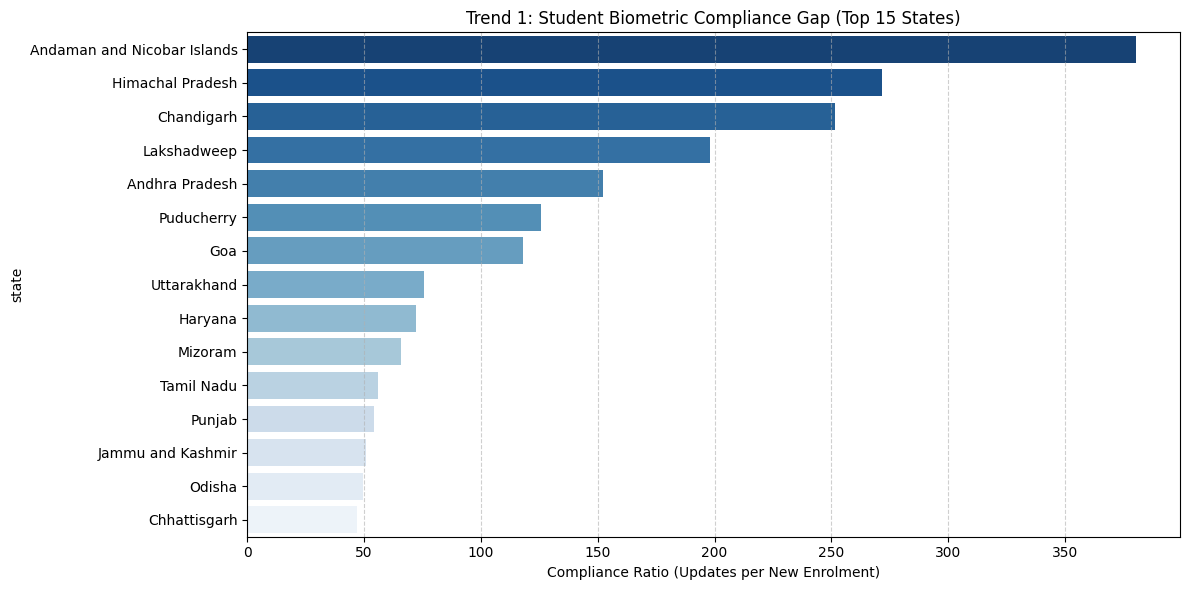

C:\Users\Reanna Netto\AppData\Local\Temp\ipykernel_3596\1277572744.py:87: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=migration_trend, x='migration_intensity', y='state', palette='Oranges_r')


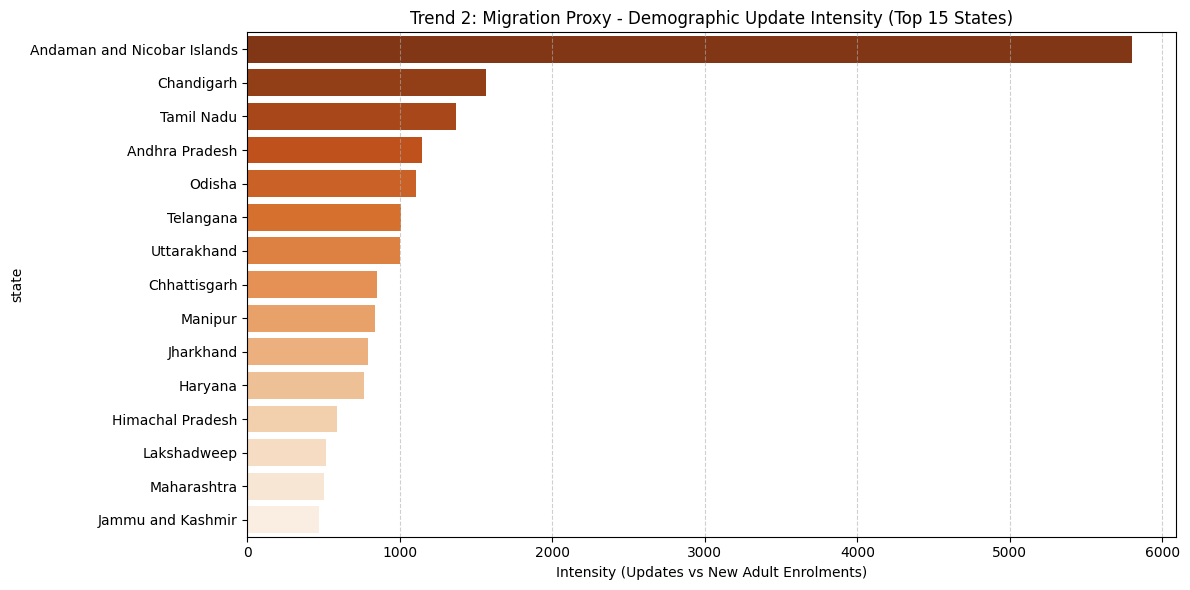

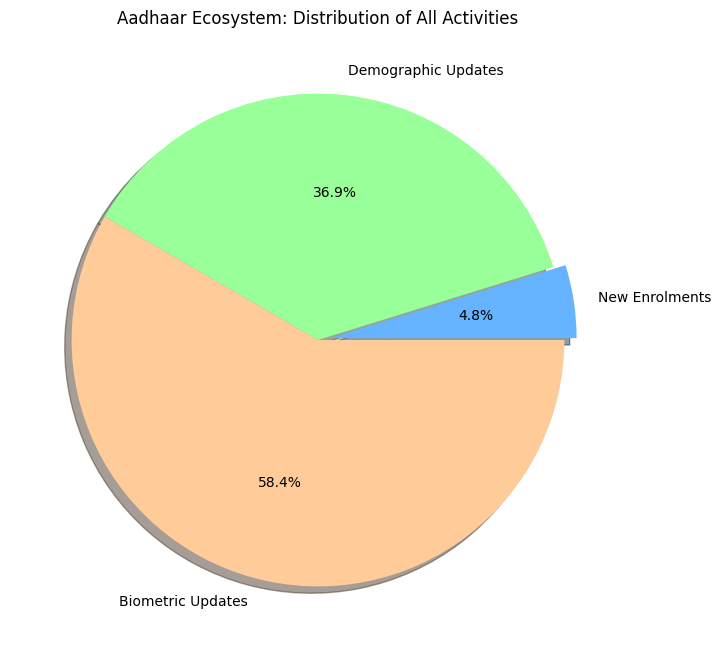

Trend Analysis Complete. 3 Images saved.


In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Load your master dataset

df = pd.read_csv('aadhaar_master_dataset.csv')

# --- State name standardization (REQUIRED) ---
valid_states = [
    'Andhra Pradesh','Arunachal Pradesh','Assam','Bihar','Chhattisgarh',
    'Goa','Gujarat','Haryana','Himachal Pradesh','Jharkhand','Karnataka',
    'Kerala','Madhya Pradesh','Maharashtra','Manipur','Meghalaya','Mizoram',
    'Nagaland','Odisha','Punjab','Rajasthan','Sikkim','Tamil Nadu','Telangana',
    'Tripura','Uttar Pradesh','Uttarakhand','West Bengal',
    'Andaman and Nicobar Islands','Chandigarh',
    'Dadra and Nagar Haveli and Daman and Diu','Delhi',
    'Jammu and Kashmir','Ladakh','Lakshadweep','Puducherry'
]

state_mapping = {
    'Jammu & Kashmir': 'Jammu and Kashmir',
    'Jammu And Kashmir': 'Jammu and Kashmir',
    'Chhatisgarh': 'Chhattisgarh',
    'Orissa': 'Odisha',
    'The Dadra And Nagar Haveli And Daman And Diu': 'Dadra and Nagar Haveli and Daman and Diu',
    'Dadra & Nagar Haveli': 'Dadra and Nagar Haveli and Daman and Diu',
    'Daman & Diu': 'Dadra and Nagar Haveli and Daman and Diu',
    'Daman and Diu': 'Dadra and Nagar Haveli and Daman and Diu',
    'Uttaranchal': 'Uttarakhand',
    'Pondicherry': 'Puducherry'
}

def clean_state(name):
    if not isinstance(name, str):
        return "Remove"
    name = name.strip()
    if name in state_mapping:
        return state_mapping[name]
    for s in valid_states:
        if name.lower() == s.lower():
            return s
    return "Remove"

df['state'] = df['state'].apply(clean_state)
df = df[df['state'] != "Remove"].copy()

# --- TREND 1: MANDATORY BIOMETRIC COMPLIANCE (AGE 5-17) ---
# Logic: UIDAI requires updates at age 5 and 15. 
# We compare Biometric Updates vs New Enrolments for students.
state_compliance = df.groupby('state').agg({
    'age_5_17': 'sum',      # New Student Enrolments
    'bio_age_5_17': 'sum'   # Student Biometric Updates
}).reset_index()

# Compliance Ratio: Higher means the state is better at ensuring students update biometrics
state_compliance['compliance_ratio'] = state_compliance['bio_age_5_17'] / (state_compliance['age_5_17'] + 1)
state_compliance = state_compliance.sort_values('compliance_ratio', ascending=False).head(15)

# Plot Trend 1
plt.figure(figsize=(12, 6))
sns.barplot(data=state_compliance, x='compliance_ratio', y='state', palette='Blues_r')
plt.title('Trend 1: Student Biometric Compliance Gap (Top 15 States)')
plt.xlabel('Compliance Ratio (Updates per New Enrolment)')
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig('trend1_compliance_gap.png')
plt.show()


# --- TREND 2: MIGRATION PROXY (DEMOGRAPHIC UPDATES) ---
# Logic: Areas with high Demographic Updates (address/name changes) but 
# low New Enrolments usually indicate "Receiver Hubs" where people move for work.
df['migration_activity'] = df['demo_age_17_']  # Adult Demographic Updates
df['new_adult_enrolment'] = df['age_18_greater']

migration_trend = df.groupby('state').agg({
    'migration_activity': 'sum',
    'new_adult_enrolment': 'sum'
}).reset_index()

migration_trend['migration_intensity'] = migration_trend['migration_activity'] / (migration_trend['new_adult_enrolment'] + 1)
migration_trend = migration_trend.sort_values('migration_intensity', ascending=False).head(15)

# Plot Trend 2
plt.figure(figsize=(12, 6))
sns.barplot(data=migration_trend, x='migration_intensity', y='state', palette='Oranges_r')
plt.title('Trend 2: Migration Proxy - Demographic Update Intensity (Top 15 States)')
plt.xlabel('Intensity (Updates vs New Adult Enrolments)')
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig('trend2_migration_proxy.png')
plt.show()


# --- BONUS: TOTAL ECOSYSTEM COMPOSITION (PIE CHART) ---
# This gives a birds-eye view of all activity types
totals = {
    'New Enrolments': df[['age_0_5', 'age_5_17', 'age_18_greater']].sum().sum(),
    'Demographic Updates': df[['demo_age_5_17', 'demo_age_17_']].sum().sum(),
    'Biometric Updates': df[['bio_age_5_17', 'bio_age_17_']].sum().sum()
}

plt.figure(figsize=(8, 8))
plt.pie(totals.values(), labels=totals.keys(), autopct='%1.1f%%', 
        colors=['#66b3ff','#99ff99','#ffcc99'], explode=(0.05, 0, 0), shadow=True)
plt.title('Aadhaar Ecosystem: Distribution of All Activities')
plt.savefig('ecosystem_pie_chart.png')
plt.show()

print("Trend Analysis Complete. 3 Images saved.")